In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

In [3]:
def humanbytes(B):
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1024)
   MB = float(KB ** 2) # 1,048,576
   GB = float(KB ** 3) # 1,073,741,824
   TB = float(KB ** 4) # 1,099,511,627,776

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB)

In [4]:
'''set day'''
day_date = datetime(2017,9,1)
print(day_date)

2017-09-01 00:00:00


In [5]:
'''set station'''
print('load station')
haifa_station = gs.Station('Haifa')
haifa_station.location

load station


'Haifa'

In [6]:
''''Set paths for small tests'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
#lidar_parent_folder = haifa_station.lidar_src_folder
# changing the path for dev
haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')
haifa_station.molecular_src_folder =  os.path.join('.','data examples','molecular_dataset')
haifa_station.lidar_src_folder = os.path.join('.','data examples','netcdf')
print(haifa_station)

<class 'global_settings.Station'>: {'name': 'Haifa', 'location': 'Haifa', 'lon': 35.02, 'lat': 32.8, 'altitude': 229.0, 'start_bin_height': 78.75, 'end_bin_height': 22485.66016, 'n_bins': 3000, 'dt': 5.0000000000000004e-08, 'gdas1_folder': '.\\data examples\\gdas', 'gdastxt_folder': '.\\data examples\\gdas_txt', 'lidar_src_folder': '.\\data examples\\netcdf', 'molecular_src_folder': '.\\data examples\\molecular_dataset', 'db_file': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\pollyxt_tropos_calibration.db', 'lidar_parent_folder': nan}


In [7]:
#gdas1_folder,gdas1_paths = prep.get_gdas_paths(haifa_station, day_date,'gdas1')
#print('gdas1',gdas1_paths)
CONVERT_GDAS = False
if CONVERT_GDAS:
	#convert cur day (gdas files from TROPOS to txt)

	gdastxt = prep.convert_daily_gdas ( haifa_station, day_date)
	print('gdas_txt',gdastxt)

	#convert next day (gdas files from TROPOS to txt)
	next_day = day_date + timedelta ( days = 1 )
	gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
	# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))
	print('gdas_txt next day',gdastxt_nextday)

	#%% convert gdas files for a period
	start_day =  datetime(2019,4,3)
	end_day = datetime(2019,4,20)
	chunk_paths = prep.convert_periodic_gdas(haifa_station,start_day, end_day)
	print(chunk_paths)



In [8]:
SHOW_MOL_DF = False
if SHOW_MOL_DF:
	'''set parameters'''
	lambda_nm = gs.LAMBDA_nm().G
	df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )
	# Visualizing molecular profiles

	plt.figure()
	ax = df_beta.plot()
	ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
	plt.show()

In [9]:
def generate_daily_molecular_chan(station, day_date, lambda_nm, time_res='30S',
                                  height_units ='Km', optim_size=False, verbose = False):
	"""
	Generating daily molecular profiles for a given channel's wavelength
	:param station: gs.station() object of the lidar station
	:param day_date: datetime.date object of the required date
	:param lambda_nm: wavelength in [nm], e.g, for green lambda_nm = 532.0 [nm]
	:param time_res: Output time resolution required. default is 30sec (according to time resolution of pollyXT measurements)
	:param height_units:  Output units of height grid in 'Km' (default) or 'm'
	:param optim_size: Boolean. False(default): the retrieved values are of type 'float64',
	                            True: the retrieved values are of type 'float'.
	:param verbose: Boolean. False(default). True: prints information regarding size optimization.
	:return: xarray.Dataset() holding 4 data variables:
	3 daily dataframes: beta,sigma,att_bsc with shared dimensions (Height, Time)
	and
	1 shared variable: lambda_nm with dimension (Wavelength)
	"""

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''
	import xarray as xr
	df_sigma , df_beta = prep.get_daily_molecular_profiles ( station , day_date , lambda_nm , height_units )

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_sigma_df.columns.freq = None
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	if height_units=='Km':
		# converting height index to meters before tau calculations
		km_index = interp_sigma_df.index.tolist()
		meter_index = (np.array(km_index.copy())*1e+3).tolist()
		interp_sigma_df.reindex(meter_index)
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	if height_units=='Km':
		# converting back height index to km before dataset creation
		interp_sigma_df.reindex(km_index)
		e_tau_df.reindex(km_index)

	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)

	''' memory size - optimization '''
	if optim_size:
		if verbose:
			print('Memory optimization - converting molecular values from double to float')
			size_beta = interp_beta_df.memory_usage(deep=True).sum()
			size_sigma = interp_sigma_df.memory_usage(deep=True).sum()
			size_att_bsc = att_bsc_mol_df.memory_usage(deep=True).sum()

		interp_beta_df = (interp_beta_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')
		interp_sigma_df = (interp_sigma_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')
		att_bsc_mol_df = (att_bsc_mol_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')

		if verbose:
			size_beta_opt = interp_beta_df.memory_usage(deep=True).sum()
			size_sigma_opt = interp_sigma_df.memory_usage(deep=True).sum()
			size_att_bsc_opt = att_bsc_mol_df.memory_usage(deep=True).sum()
			print('Memory saved for wavelength {} beta: {:.2f}%, sigma: {:.2f}%, att_bsc:{:.2f}%'.
			      format(lambda_nm,100.0*float(size_beta-size_beta_opt)/float(size_beta),
			             100.0*float(size_sigma-size_sigma_opt)/float(size_sigma),
			             100.0*float(size_att_bsc-size_att_bsc_opt)/float(size_att_bsc)))

	''' Create molecular dataset'''
	ds_chan = xr.Dataset(
        data_vars   =   {  'beta'   :   (('Height', 'Time'), interp_beta_df ),
                           'sigma'  :   (('Height', 'Time'), interp_sigma_df),
                           'attbsc':    (('Height', 'Time'), att_bsc_mol_df ),
                           'lambda_nm': ( 'Wavelength'     , np.uint16([lambda_nm]))
                        },
        coords  =   {   'Height': interp_beta_df.index.to_list(),
                        'Time': interp_beta_df.columns,
                        'Wavelength': np.uint16([lambda_nm])
                        }
	)

	# set attributes of data variables
	ds_chan.beta.attrs =  {'long_name':r'$\beta$',  'units':r'$1/m \cdot sr$',
	                       'info': 'Molecular backscatter coefficient'}
	ds_chan.sigma.attrs = {'long_name':r'$\sigma$', 'units':r'$1/m $',
	                       'info': 'Molecular attenuation coefficient'}
	ds_chan.attbsc.attrs = {'long_name':r'$\beta \cdot \exp(-2\tau)$',  'units':r'$1/m \cdot sr$',
	                        'info': 'Molecular attenuated backscatter coefficient'}
	# set attributes of coordinates
	ds_chan.Height.attrs = {'units':'{}'.format ( height_units ),'info': 'Measurements heights above sea level'}
	ds_chan.Wavelength.attrs = {'long_name':r'$\lambda$', 'units':r'$nm$'}


	return ds_chan

def generate_daily_molecular(station, day_date, time_res='30S',
                                  height_units ='Km', optim_size=False, verbose = False):
	"""
	Generating daily molecular profiles for all elastic channels (355,532,1064)
	:param station: gs.station() object of the lidar station
	:param day_date: datetime.date object of the required date
	:param time_res: Output time resolution required. default is 30sec (according to time resolution of pollyXT measurements)
	:param height_units:  Output units of height grid in 'Km' (default) or 'm'
	:param optim_size: Boolean. False(default): the retrieved values are of type 'float64',
	                            True: the retrieved values are of type 'float'.
	:param verbose: Boolean. False(default). True: prints information regarding size optimization.
	:return: xarray.Dataset() holding 5 data variables:
			 3 daily dataframes: beta,sigma,att_bsc with shared dimensions(Height, Time, Wavelength)
			 and 2 shared variables: lambda_nm with dimension (Wavelength), and date
	"""
	wavelengths = gs.LAMBDA_nm().get_elastic()
	ds_list = []
	#from pytictoc import TicToc
	#t = TicToc()
	#t.tic()
	for lambda_nm in wavelengths:
		ds_chan = generate_daily_molecular_chan(station, day_date, lambda_nm, time_res=time_res,
		                                        height_units =height_units, optim_size=optim_size, verbose = verbose)
		ds_list.append(ds_chan)
	#t.toc()
	'''concatenating molecular profiles of all channels'''
	ds_mol = xr.concat(ds_list,dim ='Wavelength')
	ds_mol['date'] = day_date
	ds_mol.attrs = {'info':'Daily molecular profiles'}
	ds_mol.attrs = {'location':station.name}
	return ds_mol
# save dataset to netcdf file
def save_molecular_dataset(station,dataset,save_mode='sep'):
	"""
	Save the input dataset to netcdf file
	:param station: station: gs.station() object of the lidar station
	:param dataset: array.Dataset() holding 5 data variables:
					3 daily dataframes: beta,sigma,att_bsc with shared dimensions(Height, Time, Wavelength)
					and 2 shared variables: lambda_nm with dimension (Wavelength), and date
	:param save_mode: save mode options:
					'sep' - for separated profiles (each is file is per profile per wavelength)
					'single' - save the dataset a single file per day
					'both' -saving both options
	:return: ncpaths - the paths of the saved dataset/s . None - for failure.
	"""

	try:
		date = ds.date.values
	except ValueError:
		print('The dataset does not contain a data variable named "date"')
		return None

	day_date = datetime.utcfromtimestamp(date.tolist()/1e9)
	month_folder = os.path.join(station.molecular_src_folder,
	                           day_date.strftime('%Y'),
	                           day_date.strftime('%m'))
	day_stamp = day_date.strftime('%Y_%m_%d')

	if not os.path.exists(month_folder):
	    try:
	        os.makedirs(month_folder)
	    except Exception:
	        print('Failed to create folder {}'.format(month_folder))
	        return None

	'''save the dataset to separated netcdf files: per profile per wavelength'''
	ncpaths=[]
	if save_mode in ['both','sep']:
		data_vars = list(dataset.data_vars)
		profiles = data_vars[0:3]
		shared_vars = data_vars[3:]
		# print('The data variables for profiles:' ,profiles) #For debug.should be : 'beta','sigma','attbsc'
		# print('The shared variables: ',shared_vars) #For debug.should be : 'lambda_nm' (wavelength),'date'
		for prof in profiles:
			prof_vars = [prof]
			for wav in dataset.Wavelength.values:
				prof_vars.extend(shared_vars)
				cur_profile = dataset.get(prof_vars).sel(Wavelength = wav)
				#print(cur_profile)
				file_name = '{}_{}_{}_{}_molecular.nc'.format(day_stamp,station.location,prof,wav)
				ncpath = os.path.join(month_folder,file_name)
				try:
					cur_profile.to_netcdf(ncpath,mode= 'w',
					                      format= 'NETCDF4',engine='netcdf4')
					cur_profile.close()
				except Exception:
					print('Saving dataset to {} failed'.format(ncpath))
					ncpath = None
				if ncpath:
					ncpaths.append(ncpath)

	'''save the dataset to a single netcdf'''
	if save_mode in ['both','single']:
		file_name = '{}_{}_molecular.nc'.format(day_date.strftime('%Y_%m_%d'),station.location)
		ncpath = os.path.join(month_folder,file_name)
		try:
			dataset.to_netcdf(ncpath,mode= 'w',
			                  format= 'NETCDF4',engine='netcdf4')
			dataset.close()
		except Exception:
			print('Saving dataset to {} failed'.format(ncpath))
			ncpath = None
		if ncpath:
			ncpaths.append(ncpath)
	return  ncpaths

# Load Dataset -
def load_dataset(netcdf_path):
	# print('Loading dataset file: {}'.format(netcdf_path))
	try:
		dataset = xr.open_dataset(netcdf_path,engine='netcdf4').expand_dims()
		dataset.close()
	except Exception:
		print('Failed to load {}'.format(netcdf_path))
		return None
	return dataset

In [ ]:
def get_daily_range_corr(station, day_date):
	"""

	:param station:
	:param day_date:
	:return:
	"""

	'''get netcdf paths of the attenuation backscatter for given day_date'''
	bsc_paths = prep.get_att_bsc_paths(station.lidar_src_folder, day_date)
	bsc_ds0 = load_dataset(bsc_paths[0])
	altitude = bsc_ds0.altitude.values[0]
	profiles = [dvar for dvar in list(bsc_ds0.data_vars) if 'attenuated_backscatter' in dvar]
	wavelengths = [np.uint(pname.split(sep='_')[-1].strip('nm')) for pname in profiles]


	ds_range_corrs = []
	for bsc_path in bsc_paths:
		cur_ds = load_dataset(bsc_path)
		'''get 6-hours range corrected dataset for three channels [355,532,1064]'''
		ds_chans =[]
		for (pname,lambda_nm) in zip(profiles,wavelengths):
			cur_darry = cur_ds.get(pname).transpose(transpose_coords=True)
			ds_chan = get_range_corr_ds_chan(cur_darry,altitude,lambda_nm)
			ds_chans.append(ds_chan)

		cur_ds_range_corr = xr.concat(ds_chans,dim ='Wavelength')
		ds_range_corrs.append(cur_ds_range_corr)

	'''merge range corrected of lidar through 24-hours'''
	ds_range_corr = xr.merge(ds_range_corrs, compat='no_conflicts')
	ds_range_corr['date']= day_date
	ds_range_corr.attrs['location'] = station.location
	ds_range_corr.attrs['info'] = 'Daily range corrected lidar signal'
	return ds_range_corr

def get_range_corr_ds_chan(darray,altitude,lambda_nm):
	LC = darray.attrs['Lidar_calibration_constant_used']
	times =  pd.to_datetime([ datetime.utcfromtimestamp(np.round(vtime)) for vtime in darray.time.values]).values
	heights_km = (1e-3) * (darray.height.values + altitude)
	rangecorr_df = pd.DataFrame( LC * darray.values ,index = heights_km,columns = times)

	''' Create range_corr_chan lidar dataset'''
	range_corr_ds_chan = xr.Dataset(
	    data_vars   =   {  'range_corr':    (('Height', 'Time'), rangecorr_df ),
	                       'lambda_nm' :    ( 'Wavelength'     , [lambda_nm]  )
	                    },
	    coords  =   {   'Height': rangecorr_df.index.to_list(),
	                    'Time': rangecorr_df.columns,
	                    'Wavelength': [lambda_nm]
	                    }
	)
	range_corr_ds_chan.range_corr.attrs = {'long_name':r'$\beta \cdot \exp(-2\tau)$',
	                                       'units':r'$photons \cdot m^2$',
	                                       'info': 'Range corrected lidar signal from attenuated backscatter multiplied with LC'}
	# set attributes of coordinates
	range_corr_ds_chan.Height.attrs = {'units':'{}'.format ( 'Km' ), 'info': 'Measurements heights above sea level'}
	range_corr_ds_chan.Wavelength.attrs = {'long_name':r'$\lambda$', 'units':r'$nm$'}

	return  range_corr_ds_chan

In [10]:
%%prun -s cumulative
print('create daily molecular dataset')
ds =  generate_daily_molecular(haifa_station,day_date,optim_size = True)
ds

create daily molecular dataset
 

In [12]:
print('Saving dataset to:')
netcdfs = save_molecular_dataset(haifa_station,ds,save_mode='both')
netcdfs

Saving dataset to:


['.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_beta_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_beta_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_beta_1064_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_sigma_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_sigma_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_sigma_1064_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_attbsc_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_attbsc_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_attbsc_1064_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_Haifa_molecular.nc']

In [13]:
netcdf = netcdfs[-1]
ds_load = load_dataset(netcdf)
ds_load

<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Height      (Height) float64 0.3078 0.3152 0.3227 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
  * Wavelength  (Wavelength) uint64 355 532 1064
Data variables:
    beta        (Wavelength, Height, Time) float32 7.676152e-06 ... 5.0566884...
    sigma       (Wavelength, Height, Time) float32 6.527236e-05 ... 4.2943626...
    attbsc      (Wavelength, Height, Time) float32 7.908775e-06 ... 5.058327e-09
    lambda_nm   (Wavelength) uint16 355 532 1064
    date        datetime64[ns] 2017-09-01
Attributes:
    location:  Haifa

In [14]:
netcdf = netcdfs[0]
ds_load_prof =load_dataset(netcdf)
ds_load_prof

<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 2880)
Coordinates:
  * Height      (Height) float64 0.3078 0.3152 0.3227 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    Wavelength  uint64 ...
Data variables:
    beta        (Height, Time) float32 7.676152e-06 ... 4.4544257e-07
    lambda_nm   uint16 355
    date        datetime64[ns] 2017-09-01
Attributes:
    location:  Haifa

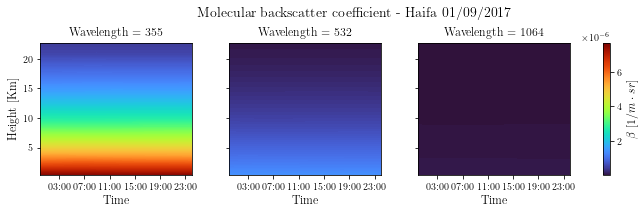

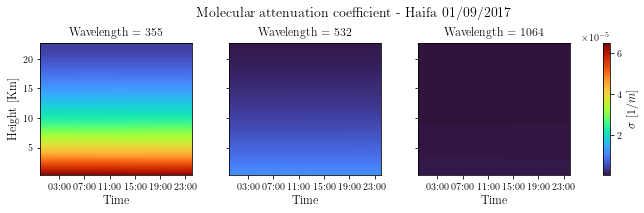

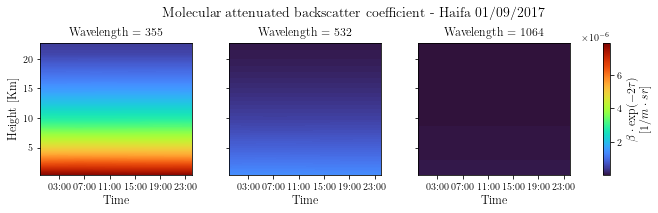

In [15]:
VIS_DS = True
if VIS_DS:
	profileTypes = list(ds.data_vars)[0:3]
	#list(ds.data_vars)[3:]
	xfmt = mdates.DateFormatter('%H:%M')
	timetics = ds.Time.dt.strftime('%H:%M')
	timetics

	for row,prof in enumerate(profileTypes):
		ds_var = ds[prof]
		g = ds_var.plot(x='Time',y='Height',col='Wavelength',
		                  col_wrap = 3,cmap = 'turbo')# , figsize = (5,8)) #TODO: figure out how to enlarge the figsize, it doesn't work properly :-(
		for ax in g.axes.flat:
			ax.xaxis.set_major_formatter(xfmt)
			ax.xaxis_date()
			ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))
			plt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')
			#if row in [0,1]:
			#	ax.xaxis.set_ticklabels([])
			#	ax.set_xlabel(None)
			#if row in [1,2]:
			#	ax.set_title(None)

		date_64 = ds.date.values
		date_datetime = datetime.utcfromtimestamp(date_64.tolist()/1e9)
		date_str = date_datetime.strftime('%d/%m/%Y')
		plt.suptitle('{} - {} {}'.format(ds_var.attrs['info'],ds.attrs['location'],date_str), y = 1.05)
		#plt.tight_layout()
		plt.show()


In [16]:
RUN_PD= False
if RUN_PD:
	print('retrieve a sub-dataframe from a dataset - according wavelength')
	df_test_beta = ds.beta.sel(Wavelength=355).to_pandas()
	df_test_beta

In [17]:
RUN_SLICE= False
if RUN_SLICE:
	print('retrieve a sub-dataframe from a dataset - according time slice')

	start_time = datetime(2017,9,1,0,30)
	end_time = start_time + timedelta(hours = 6) #datetime(2017,9,1,12,30)
	timestamps = pd.date_range ( start = start_time , end = end_time  ,
	                             freq = timedelta ( seconds = 30 ) )
	#slice_beta= mol_xr.loc['beta'].to_pandas().loc[:,timestamps]
	print('slicing data set by time')
	sub_ds = ds.sel(Time =slice(start_time,end_time))#  timestamps).plot()#=slice(start_time,start_time+timedelta(hours = 6)))

	sub_ds

In [18]:
CALC_SIZE = False
if CALC_SIZE:
	profiles = list(ds.data_vars)[0:3]
	total_size =0
	for prof in profiles:
		for wav in ds.Wavelength.values:
			tmp_prof = (ds[prof]).sel(Wavelength=wav).to_pandas()
			cursize = tmp_prof.memory_usage(deep=True).sum()
			print('profile:{}, wavelength: {}, size:{}'.format(prof,wav,humanbytes(cursize)))
			total_size+=cursize

	print('total size of data set is at least:{}'.format(humanbytes(total_size)))


In [ ]:
ds_range_corr_daily = get_daily_range_corr(haifa_station, day_date)
ds_range_corr_daily


In [ ]:
xfmt = mdates.DateFormatter('%H:%M')
timetics = ds_range_corr_daily.Time.dt.strftime('%H:%M')
timetics

g = ds_range_corr_daily.range_corr.plot(x='Time',y='Height',row='Wavelength',
                  row_wrap = 3,cmap = 'turbo')# , figsize = (5,8)) #TODO: figure out how to enlarge the figsize, it doesn't work properly :-(
for ax in g.axes.flat:
	ax.xaxis.set_major_formatter(xfmt)
	ax.xaxis_date()
	ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))
	plt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')

date_64 = ds_range_corr_daily.date.values
date_datetime = datetime.utcfromtimestamp(date_64.tolist()/1e9)
date_str = date_datetime.strftime('%d/%m/%Y')
plt.suptitle('{} - {} {}'.format(ds_range_corr_daily.attrs['info'],ds_range_corr_daily.attrs['location'],date_str), y = 1.05)
#plt.tight_layout()
plt.show()

In [ ]:
sub_ds = ds_range_corr_daily.sel(Wavelength =532).get('range_corr')
#pos_rangecorr = ds_range_corr_daily.sel(Wavelength =355).where(ds_range_corr_daily.range_corr>0,drop=False)
sub_ds.where(sub_ds>- 1e-5).plot(cmap = 'turbo')
#pos_rangecorr

#.plot(x='Time',y='Height',col='Wavelength',
#                  col_wrap = 3,cmap = 'turbo')
#plt.show()

#eps = np.finfo(np.float).eps
#print(eps)
#ds_mask = ds_range_corr_daily.where(ds_range_corr_daily.range_corr<0)
#res = ds_range_corr_daily.range_corr<0
#ds_range_corr_daily.where(ds_range_corr_daily.range_corr<0,None)
#ds_range_corr_daily.range_corr.min()
#res

In [ ]:
profiles_paths = prep.get_profiles_paths(haifa_station.lidar_src_folder, day_date)
print(profiles_paths)
prof_path = profiles_paths[0]
#profile_paths



In [20]:
# TODO: extend save_molecular_dataset to save range_corr.nc (change the string in the name)
# TODO: split each sataset of range corrected to 2 : one contains the exponent of 10 , and the other the base (less importanat for now)
# TODO: range corrected visualization -> why most of values are close to zero ? check about the data range. show histogram
# TODO: convert from xarray to pytorch
# TODO: lidar_parent_folder - should be similar to lidar_src_folder. why was added to stations.csv?
# TODO: update environment installations ARLreader and pytorch
# TODO: check with Shubi table of samples (for the data loader)
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.



In [ ]:
'''
import logging
logger = logging.getLogger()

day_dates = pd.date_range(start=start_day, end=end_day, freq=timedelta(days=1))
expected_file_no = len(day_dates) * 8  # 8 timestamps per day
gdastxt_paths = []
for day in day_dates:
    gdastxt_paths.extend(prep.convert_daily_gdas(haifa_station, day))
total_converted = len(gdastxt_paths)
logger.debug(f"Done conversion of {total_converted} gdas files from {start_day.strftime('%Y/%m/%d')} to "
             f"{end_day.strftime('%Y/%m/%d')}, {(expected_file_no - total_converted)} failed.")

'''